In [1]:
import numpy as np
import os
from pathlib import Path

import matplotlib.pyplot as plt
from keras.preprocessing import image

import matplotlib.pyplot as plt

2022-05-09 10:42:42.726734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 10:42:42.726762: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
p = Path("./Images/")
dirs = p.glob("*")
labels_dict = {'cats':0, 'dogs':1, 'horses':2, 'humans': 3}

image_data = []
labels = []    


for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1]
    i = 0
    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

In [3]:
print(len(image_data))
print(len(labels))

808
808


In [4]:
## Convert data into numpy array

image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)
print(image_data.shape, labels.shape)

(808, 32, 32, 3) (808,)


In [5]:
## Randomly shuffle data

import random 
combined = list(zip(image_data, labels))
random.shuffle(combined)

image_data[:], labels[:] = zip(*combined)

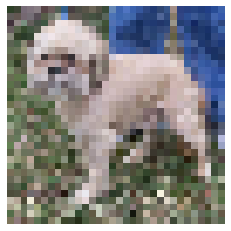

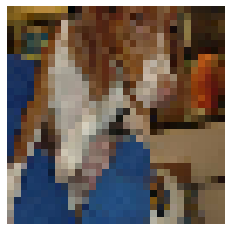

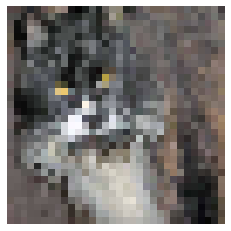

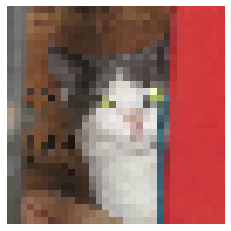

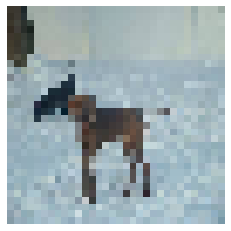

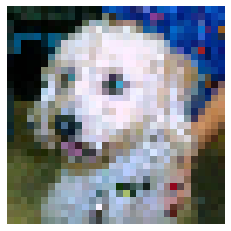

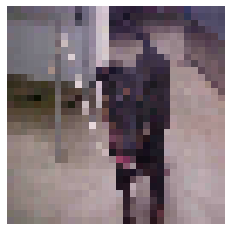

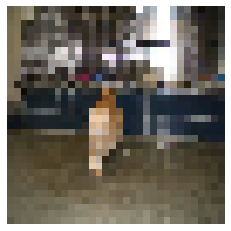

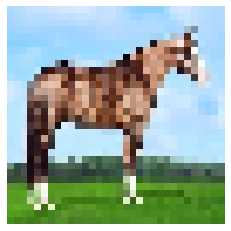

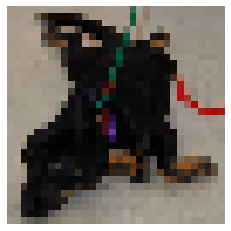

In [6]:
## Visualize the data

def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

for i in range(10):
    drawImg(image_data[i+500])

In [7]:
print(image_data.shape)
M = image_data.shape[0]
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(808, 32, 32, 3)
(808, 3072)
(808,)


In [8]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

In [9]:
number_of_classes = len(np.unique(labels))

In [10]:
def classWiseData(x, y):
    data = {}
    
    for i in range(number_of_classes):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k], dtype = 'float32')
        
    return data

In [11]:
data = classWiseData(image_data, labels)

In [12]:
print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
print(data[3].shape[0])

202
202
202
202


In [13]:
def getDataPairForSVM(d1,d2):
    
    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair, data_labels

In [14]:
mySVM = SVM()
# xp, yp = getDataPairForSVM(data[0], data[1])
# w,b,loss = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
# plt.plot(loss)

In [15]:
def trainSVMsOneVOne(x,y):
    svm_classifiersOvO = {}
    
    for i in range(number_of_classes):
        svm_classifiersOvO[i] = {}
        for j in range(i+1, number_of_classes):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiersOvO[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    return svm_classifiersOvO

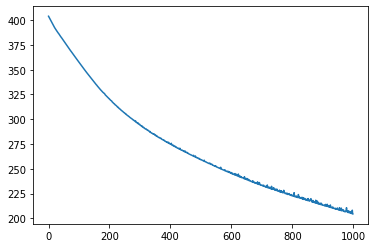

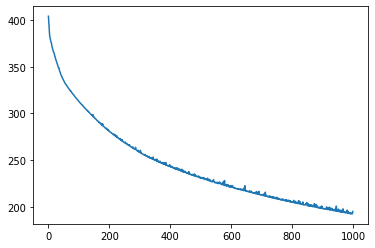

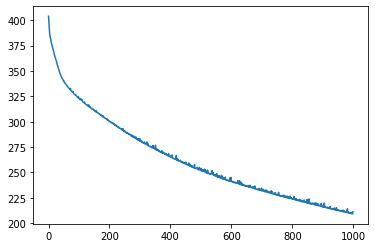

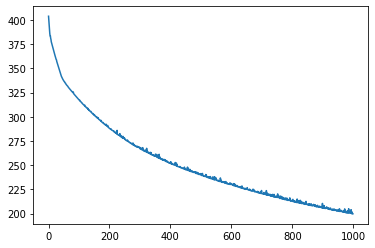

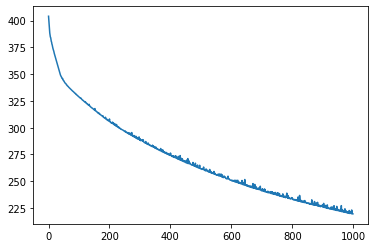

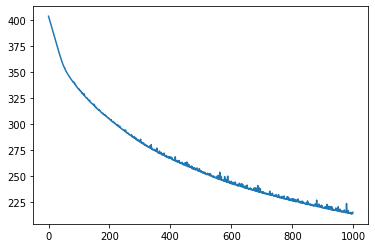

In [16]:
svm_classifiersOvO = trainSVMsOneVOne(image_data, labels)

In [50]:
import pprint
pprint.pprint(svm_classifiersOvO)

{0: {1: (array([[-0.01038734,  0.02181779,  0.00385943, ..., -0.02496537,
        -0.0149458 , -0.02077053]]),
         -0.025440000000000036),
     2: (array([[-0.00111435,  0.00639229,  0.01114496, ...,  0.01446597,
         0.01852781, -0.01537511]]),
         -0.12766000000000002),
     3: (array([[ 0.0092723 ,  0.01427901, -0.00526266, ..., -0.00612144,
        -0.01257611, -0.01580038]]),
         -0.08711999999999977)},
 1: {2: (array([[-0.01135094, -0.02820669, -0.00626302, ...,  0.03196457,
         0.03128015,  0.00910126]]),
         -0.10059000000000001),
     3: (array([[ 0.00879751, -0.01180795, -0.00783346, ...,  0.02104688,
         0.00891105,  0.00219819]]),
         -0.060649999999999746)},
 2: {3: (array([[ 0.01587182,  0.01324424, -0.01186149, ..., -0.00018549,
        -0.01300137,  0.01275379]]),
         0.029829999999999923)},
 3: {}}


In [17]:
def trainSVMsOneVAll(x,y):
    svm_classifiersOvA = {}
    
    data = classWiseData(x,y)
    svm_classifiersOvA = {}
    for i in range(number_of_classes):
        data2 = [] 
        for j in range(number_of_classes):
            if i != j:
                temp = list(data[j])
                data2 = data2 + temp
                
        data2 = np.array(data2, dtype = 'float32')
        xpair,ypair = getDataPairForSVM(data[i],data2)
        wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1000)
        svm_classifiersOvA[i] = (wts,b)
        
        plt.plot(loss)
        plt.show()
            
    return svm_classifiersOvA

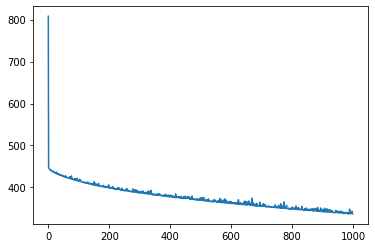

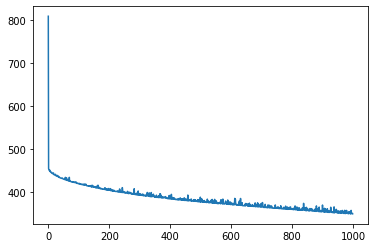

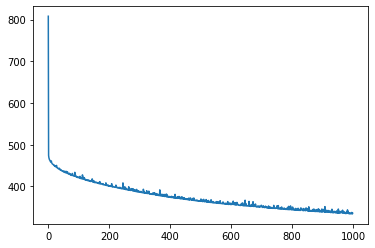

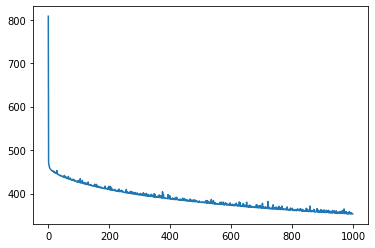

In [18]:
svm_classifiersOvA = trainSVMsOneVAll(image_data, labels)

In [51]:
pprint.pprint(svm_classifiersOvA)

{0: (array([[-0.00309375,  0.00514039, -0.00414574, ...,  0.01118003,
         0.0111071 ,  0.00232279]]),
     0.13225999999999935),
 1: (array([[ 0.01472258, -0.00547698,  0.00739454, ...,  0.01727928,
         0.01250453,  0.00496939]]),
     0.16070000000000362),
 2: (array([[ 0.01659912,  0.01812266,  0.0039413 , ..., -0.01935257,
        -0.02029673,  0.01438716]]),
     0.23555000000000167),
 3: (array([[-0.01290193, -0.0095729 , -0.00988864, ...,  0.01001973,
         0.00978931,  0.00923437]]),
     0.24259000000000291)}


In [38]:
classes = ['cats', 'dogs', 'horses', 'humans']

In [19]:
def binaryPredict(x,w,b, slack = 1):
    z = np.dot(x,w.T) + b
    if z >= 1-slack:
        return 1
    else:
        return -1

In [20]:
def predictOneVOne(x):
    
    count = np.zeros((number_of_classes,))
    
    for i in range(number_of_classes):
        for j in range(i+1, number_of_classes):
            w,b = svm_classifiersOvO[i][j]
            
            #Take a majority prediction
            z = binaryPredict(x,w,b)
            
            if z==1:
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    return final_prediction

In [93]:
def predictOneVAll(x):
    final_prediction = -1
    z0 = -1
    for i in range(number_of_classes):
        
        w,b = svm_classifiersOvA[i]
        z = np.dot(x,w.T) + b
#         print(f"{z}: {classes[i]}")
        if z > z0:
            final_prediction = i
            z0 = z
            
    return final_prediction

In [52]:
def accuracyOneVOne(x,y):
    
    pred = []
    count=0
    
    for i in range(x.shape[0]):
        prediction = predictOneVOne(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1
    
    return count/x.shape[0], pred

In [86]:
def accuracyOneVAll(x,y):
    
    pred = []
    count=0
    
    for i in range(x.shape[0]):
        prediction = predictOneVAll(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1
            
#         if i%4 == 1:
#             count += 1;
    
    return count/x.shape[0], pred

In [24]:
accOvO, ypredOvO = accuracyOneVOne(image_data, labels)
print(accOvO)

0.5754950495049505


In [25]:
for itr in range(10):
    print(f"ypredOvO: {ypredOvO[itr]} vs label: {labels[itr]} ")

ypredOvO: 3 vs label: 0 
ypredOvO: 3 vs label: 3 
ypredOvO: 2 vs label: 2 
ypredOvO: 1 vs label: 1 
ypredOvO: 0 vs label: 0 
ypredOvO: 3 vs label: 1 
ypredOvO: 2 vs label: 2 
ypredOvO: 3 vs label: 2 
ypredOvO: 3 vs label: 3 
ypredOvO: 1 vs label: 1 


In [87]:
accOvA, ypredOvA = accuracyOneVAll(image_data, labels)
print(accOvA)

0.24133663366336633


In [98]:
for itr in range(10):
    print(f"ypredOvO: {ypredOvA[itr*20]} vs label: {labels[itr*20]} ")

ypredOvO: 3 vs label: 0 
ypredOvO: 3 vs label: 0 
ypredOvO: 3 vs label: 1 
ypredOvO: 3 vs label: 3 
ypredOvO: 3 vs label: 1 
ypredOvO: 3 vs label: 0 
ypredOvO: 3 vs label: 0 
ypredOvO: 3 vs label: 1 
ypredOvO: 3 vs label: 2 
ypredOvO: 3 vs label: 0 


In [29]:
def predict_image_OvO(img_path):
    img = image.load_img(img_path, target_size=(32,32))
    img_array = image.img_to_array(img)
    image_array = np.array(img_array, dtype='float32')/255.0
    drawImg(image_array)
    
    image_array = np.reshape(image_array, 3072)
    return classes[predictOneVOne(image_array)]

In [83]:
def predict_image_OvA(img_path):
    img = image.load_img(img_path, target_size=(32,32))
    img_array = image.img_to_array(img)
    image_array = np.array(img_array, dtype='float32')/255.0
    drawImg(image_array)
    
    image_array = np.reshape(image_array, 3072)
    return classes[predictOneVAll(image_array)]

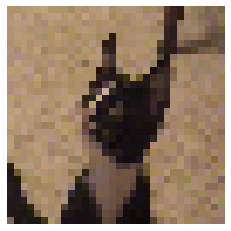

'cats'

In [95]:
test1 = "./test_images/test5.jpg"
predict_image_OvO(test1)

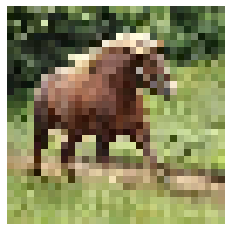

[1.50729808]: cats
[0.65262016]: dogs
[0.21819964]: horses
[0.96034155]: humans


'cats'

In [96]:
test2 = "./test_images/test8.jpg"
predict_image_OvA(test2)